# Implementação - Modelos de Volatilidade Estocástica

**Aluno:** Franklin Oliveira

-----

Nesse notebook, vamos apresentar a implementação de modelos de volatilidade estocástica (SV). Para isso, vamos adotar a formulação de modelos de espaço-estado, onde estamos interessados em estimar a volatilidade (estado - $h_t$), que não é diretamente observável, para uma série $y_t$ realizada.  

Vamos começar com o modelo mais simples...

-----

## Modelo Canônico

<center> $ y_t = \beta \exp \left\{\frac{h_t}{2} \right\} u_t~~~$ <font color='blue'>(output - medições observadas) </font></center>

<center> $ h_t = \mu + \phi(h_{t-1} - \mu) + \sigma \eta_t  ~~~$ <font color='green'>(mudança de estado) </font></center>

<center> $h_1 \sim \mathcal{N} \left(\mu, \frac{\sigma^2}{1 - \phi^2} \right)$ </center>

Onde $h_t$ é a log-volatilidade não observada de $y_t$, e $u_t$ e $\eta_t$ são ruídos brancos gaussianos, i.e., 

$$u_t \sim \mathcal{N}(\mu_u, \sigma_u^2)~~\text{e}~~\eta_t \sim \mathcal{N}(\mu_{\eta}, \sigma_{\eta}^2)$$


Para exemplificar, vamos usar esse modelo para estimar a volatilidade do índice Ibovespa.



In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal, invgamma
from scipy.stats import norm, uniform
from statsmodels.tsa.statespace.tools import is_invertible
from statsmodels.graphics.tsaplots import plot_acf
from IPython.display import clear_output

sns.set()

Vamos começar importando a série do Ibovespa...

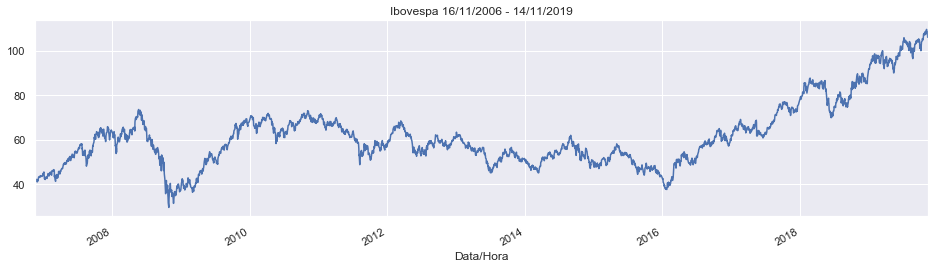

In [29]:
df = pd.read_csv('ibov.csv', sep=';', encoding='utf-8-sig', index_col=0)

# data para datetime
df['Data/Hora'] = pd.to_datetime(df['Data/Hora'], format='%d/%m/%Y')

df.set_index('Data/Hora')['Cotação'].plot(kind='line', figsize=(16,4), 
                                          title='Ibovespa 16/11/2006 - 14/11/2019')

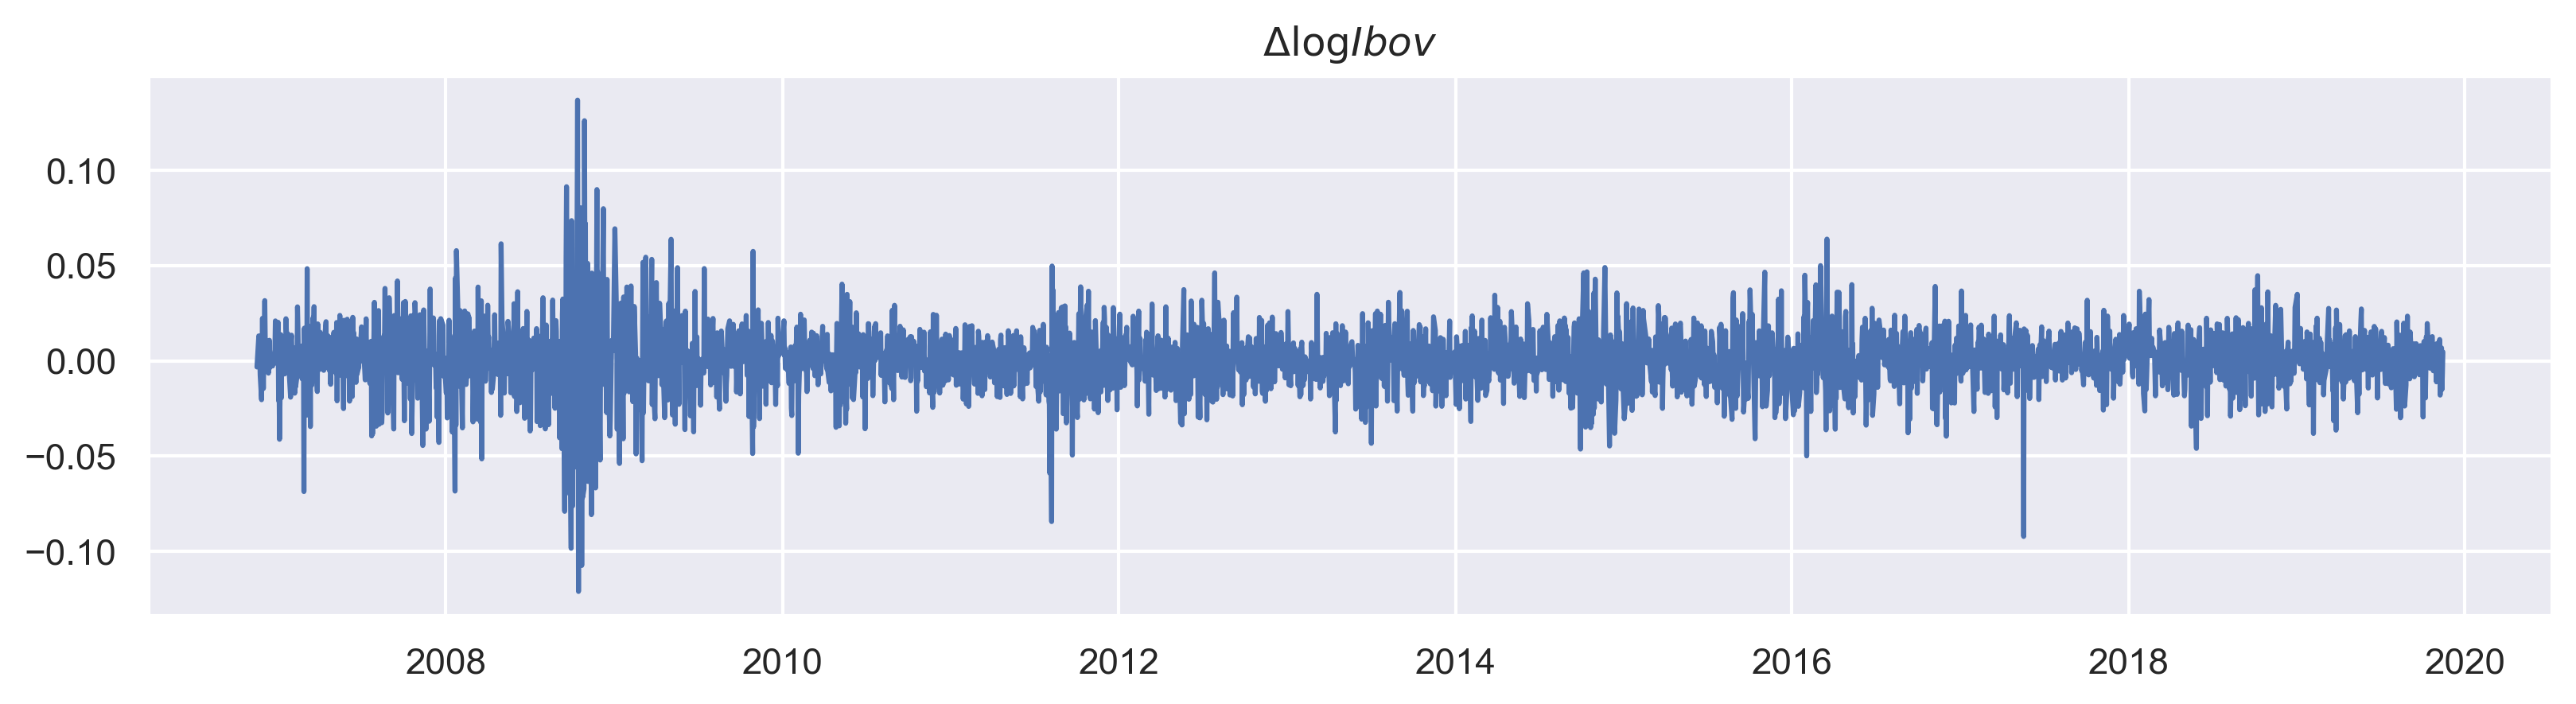

In [30]:
ibov = df.set_index('Data/Hora')['Cotação'].sort_index(ascending=True)
log_ibov = np.log(ibov).diff()[1:] 

# Plot the series to see what it looks like
fig, ax = plt.subplots(figsize=(13, 3), dpi=300)
ax.plot(log_ibov, label=r'$\Delta \log Ibov$')
ax.set_title(r'$\Delta \log Ibov$')
ax.yaxis.grid(b=True);

Tomaremos o nosso $y$ na forma de log-retorno corrigido pela média, i.e.,

$$
y_t = 100 \left\{ \left( \log IBOV_t - \log IBOV_{t-1} \right) - \frac{1}{n} \sum_{i=1}^n \left( \log IBOV_i - \log IBOV_{i-1} \right) \right\}
$$

In [31]:
# y = log-retorno corrigido pela média
y = 100*(log_ibov - np.cumsum(log_ibov)/np.array(range(1,len(ibov))))[:1000]

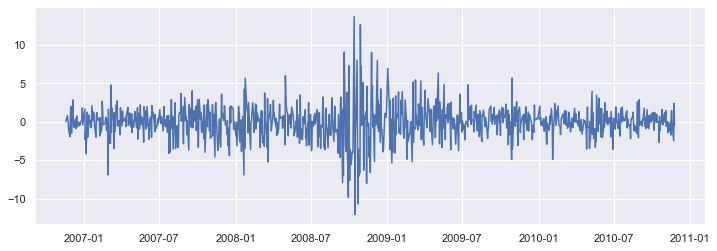

In [32]:
plt.figure(figsize=(12,4))
plt.plot(y)

## Gibbs-Sampler

No paper original (Kim, Shephard e Chib - 1998), foram executadas 1.000.000 iterações, com um *burn-in* de 50.000 observações.

In [23]:
# Passo 1: inicializando objetos
T = len(y)  # Nº de obs de Y
N = 1000    # tamanho das amostras ("batch size")

h = np.zeros(N*T).reshape(N,T)
phi = np.zeros(N).reshape(N)
s2_n = np.zeros(N).reshape(N)
mu = np.zeros(N).reshape(N)
beta = np.zeros(N).reshape(N)

# valores iniciais
phi[0] = 0.95
s2_n[0] = 0.02
# mu[0] = np.random.normal(loc=0, scale=10, size=1)  # N(0,10)
mu[0] = 0
beta[0] = np.exp(mu[0]/2)
sigma_r = 5
S_sigma = 0.01 * sigma_r

In [24]:
### Gibbs sampler
for i in range(N-1):    
    # mostra o número da iteração na tela
    clear_output()
    print('\n- Iteração:',i+1, 'de', N-1)
    
    ### Passo 2: para cada t, executo até h_t ser aceito (acc = False)
    for t in range(T-1):
        acc = True
        while acc:
            # amostrando ht de p(ht|h\t, y, phi, mu, s2_n)
            h_star = mu[i] + (phi[i] * ((h[i][t] - mu[i]) + (h[i][t+1] - mu[i])))/(1+phi[i]**2)
            v = s2_n[i]/(1+phi[i]**2)
            m = h_star + (v/2) * ((y[t]**2)*np.exp(-h_star)-1)
            h_prop = np.random.normal(loc=m, scale=v, size=1)[0]  # h proposto

            # prob de aceitação
            f_star = -(1/2)*h_prop - (y[t]**2)/2 * np.exp(-h_prop)
            g_star = -(1/2)*h_prop - (y[t]**2)/2 * np.exp(-h_prop) - h_prop * np.exp(-h_star)
            if np.random.uniform() < f_star/g_star:  # Aceito / Rejeito h_prop
                h[i][t] = h_prop # aceita h[t]
                acc = False

    ### Passo 3:  amostrando s2_n de p(s2_n|h,y,mu,phi)
    a = (N + sigma_r)
    # calcula soma_t=1^n (h_t+1 - mu)-phi(h_t-mu)^2
    soma = []
    for t in range(T-1):
        soma.append(((h[i][t+1] - mu[i])-phi[i]*(h[i][t] - mu[i]))**2) # termos do somatório    
    b = S_sigma + (h[i][0] - mu[i])**2 * (1-phi[i]**2) + np.sum(soma)
    s2_n[i+1] = 1/np.random.gamma(shape=a/2, scale= b/2, size=1)
    
    ### Passo 4: amostrando phi de p(phi | h,y,mu,s2_n)
    soma_phi = []
    soma_v = []
    for t in range(T-1):
        soma_phi.append((h[i][t+1] - mu[i])*(h[i][t] - mu[i]))
        soma_v.append((h[i][t] - mu[i])**2)
    # parâmetros da condicional
    phi_hat = np.sum(soma_phi)/np.sum(soma_v)               # média
    v_hat = s2_n[i+1]/np.sum(soma_v)                        # variância
    phi_prop = np.random.normal(phi_hat, v_hat, size=1)[0]  # phi proposto

    # probabilidade de aceitação: e^{g_prop - g}
    priori_phi_prop = (((1+phi_prop)/2)**19) * ((1-phi_prop)/2)**0.5
    g_prop = np.log(priori_phi_prop) - ((h[i][0] - mu[i])**2*(1-phi_prop**2))/2*s2_n[i+1] + 1/2*np.log(1-phi_prop**2)

    priori_phi = (((1+phi[i])/2)**19) * ((1-phi[i])/2)**0.5
    g = np.log(priori_phi) - ((h[i][0] - mu[i])**2*(1-phi[i]**2))/2*s2_n[i] + 1/2*np.log(1-phi[i]**2)
    
    if np.random.uniform() < np.exp(g_prop - g):
        phi[i+1] = phi_prop
    else:
        phi[i+1] = phi[i]
    
    ### Passo 5: amostrando mu de p(mu|h,y,phi,s2_n)
    s = s2_n[i+1]/((N-1)*(1-phi[i+1])**2 + (1-phi[i+1]**2))
    soma = []
    for t in range(T-1):
        soma.append(h[i][t+1] - phi[i+1]*h[i][t])
        
    m = s * ((1-phi[i+1]**2)*h[i][0]/s2_n[i+1] + ((1-phi[i+1])/s2_n[i+1] * np.sum(soma)))
    mu[i+1] = np.random.normal(loc=m, scale=s, size=1)[0]
    beta[i+1] = np.exp(mu[i+1]/2)


- Iteração: 999 de 999


**Agora, vamos plotar a série dos log-retornos do Ibovespa e a volatilidade "estimada".**

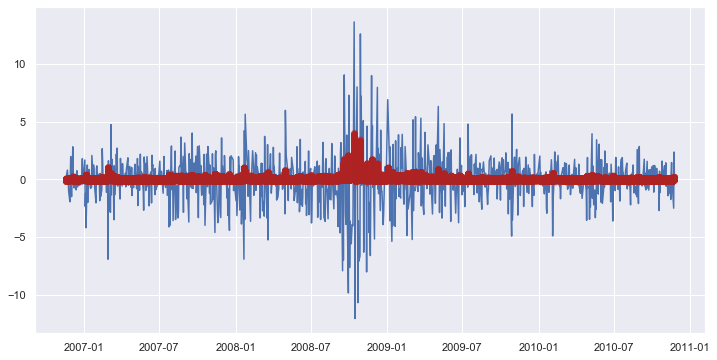

In [25]:
plt.figure(figsize=(12,6))
plt.plot(y.index,y);
plt.plot(y.index,h.T, 'ob', alpha=0.2, color='firebrick');

**Cadeias de $\phi$, $\sigma^2_{\eta}$ e $\beta$**

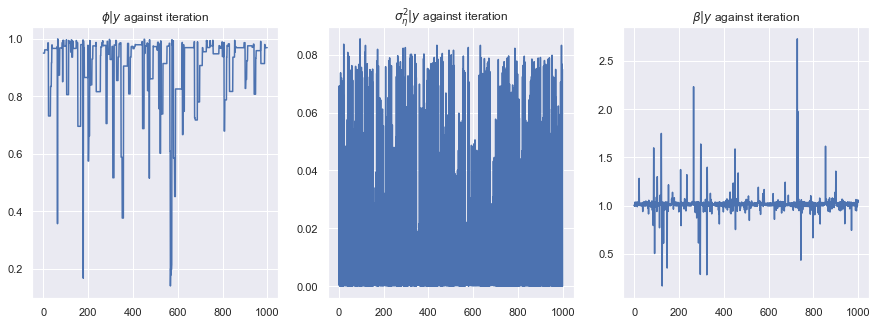

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
sns.lineplot(x=list(range(N)),y=phi, ax = ax[0])
sns.lineplot(x=list(range(N)),y=s2_n, ax = ax[1])
sns.lineplot(x=list(range(N)),y=beta, ax = ax[2])

ax[0].set_title(r'$\phi|y$ against iteration');
ax[1].set_title(r'$\sigma^2_{\eta}|y$ against iteration');
ax[2].set_title(r'$\beta|y$ against iteration');

**Distribuições de $\phi$, $\sigma^2_{\eta}$ e $\beta$**

Text(0.5, 1.0, 'Distribution of $\\beta|y$')

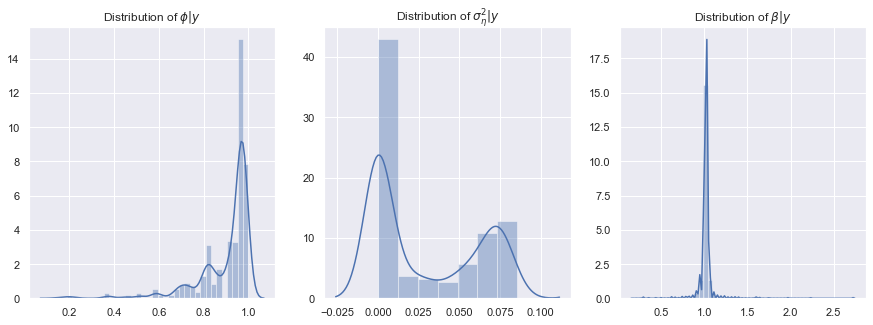

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
sns.distplot(phi, ax = ax[0], norm_hist= True)
sns.distplot(s2_n, ax = ax[1], norm_hist= True)
sns.distplot(beta, ax = ax[2], norm_hist= True)

ax[0].set_title(r'Distribution of $\phi|y$')
ax[1].set_title(r'Distribution of $\sigma^2_{\eta}|y$')
ax[2].set_title(r'Distribution of $\beta|y$')

**Autocorrelação de $\phi$, $\sigma^2_{\eta}$ e $\beta$**

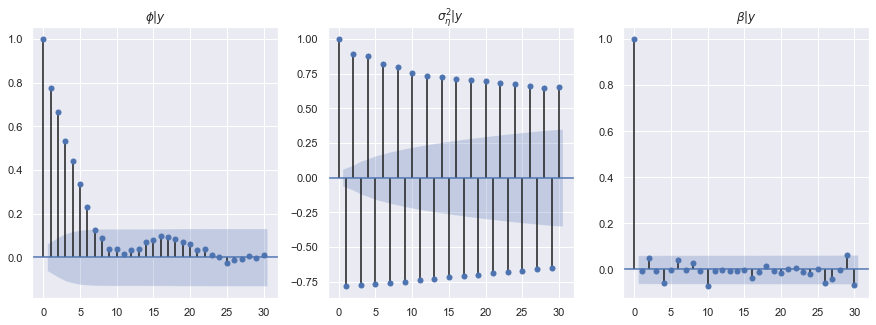

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
plot_acf(phi, ax = ax[0], title=r'$\phi | y$');
plot_acf(s2_n, ax = ax[1], title=r'$\sigma^2_{\eta} | y$');
plot_acf(beta, ax = ax[2], title=r'$\beta | y$');